## Entrenamiento con algoritmos genéticos 

Para esté entrenamiento usaremos como base el artículo *Training  Feedforward  Neural  Networks  Using  Genetic  Algorithms*. En está práctica replicaremos el experimento número 5.

En lugar de la base de datos que se usa en el artículo tomarémos un conjunto de donde se 
determina la calidad de un vino dependiendo de sus mediciones fisicoquímicas. La puedes descargar de
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ o de https://archive.ics.uci.edu/dataset/186/wine+quality

Usaremos los datos de vino blanco.

Los datos se componen de diez valores reales, que corresponenden a sus características fisicoquímicas del vino,
y un entero, que corresponde a su calidad, está etiqueta tiene valores entre 3 y 9.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
#Definimos el dispositivo que se usara.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
#device = "cpu"

Device:  cuda


In [3]:
class Gen_net(nn.Module):
    '''
    Definimos un modelo de red neuronal sobre el cual podamos 
    evaluar el algoritmo genetico.
    '''
    def __init__(self, in_features, hidden_1, hidden_2, out_features):
        '''
        Define la estructura de la red como se define en el articulo.
        Ten en cuenta que, dado que no usamos el mismo conjunto de datos
        los valores de in_features y out_features se veran afectados.
        Agregar como parametros estos valores te puede ayudar a reconstruir
        la red a partir de un cromosoma.
        '''
        super(Gen_net, self).__init__()
        self.layer1 = nn.Linear(in_features, hidden_1)
        self.layer2 = nn.Linear(hidden_1, hidden_2)
        self.layer3 = nn.Linear(hidden_2, out_features)
        self.sigmoid = nn.Sigmoid()
        
        # Calcular el numero total de pesos en la red
        self.total_weights = self.count_weights()

    def count_weights(self):
        '''
        Calcula el numero total de pesos en la red.
        '''
        total = 0
        for param in self.parameters():
            total += param.numel()
        return total
        
    def forward(self, X):
        '''
        Define la funcion de feed forward, a partir de los datos
        de X. Usa una sigmoide entre las capas.
        '''
        X = X.to(self.layer1.weight.device)  # Con esto aseguramos que X este en el mismo dispositivo que los pesos de la primera capa
        X = self.layer1(X)
        X = self.sigmoid(X)
        X = self.layer2(X)
        X = self.sigmoid(X)
        X = self.layer3(X.float())  # Casteamos a Float
        return X
        

    def build_from_chromosome(self, chromosome):
        '''
        Define una funcion para que a partir de un cromosoma modifiques los 
        pesos de la red.        
        '''
        with torch.no_grad():
            # Extraemos pesos
            w1 = torch.tensor(chromosome[:self.layer1.weight.numel()]).reshape(self.layer1.weight.shape).float()
            w2 = torch.tensor(chromosome[self.layer1.weight.numel():self.layer1.weight.numel() + self.layer2.weight.numel()]).reshape(self.layer2.weight.shape).float()
            w3 = torch.tensor(chromosome[-self.layer3.weight.numel():]).reshape(self.layer3.weight.shape).float()

            # Actualizamos pesos
            self.layer1.weight.data = w1
            self.layer2.weight.data = w2
            self.layer3.weight.data = w3
        
        
    def training(self, X, Y, optimizer):
        '''
        Define una funcion de entrenamiento como en la practica anterior, pero utilizando la misma 
        funcion de error que se usa para obtener el fitness.
        '''
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        output = self(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        return loss.item()
        



In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split


path = './wine+quality/winequality-white.csv'
def read_data(path):
    '''
    Define una funcion para leer los datos y obtener su formato correcto.
    Los datos se componene de una primer linea donde vienen los nombres de las columnas.
    Normaliza los datos y dividelos entre los conjuntos de prueba y validacion.
    '''
    # Leer el archivo CSV
    data = pd.read_csv(path, sep=';')
    
    # Normalizar los datos
    data = (data - data.mean()) / data.std()
    
    # Dividir los datos en caracteristicas (X) y etiquetas (Y)
    X = data.drop('quality', axis=1).values.astype(np.float32)  # Convertir a float32
    Y = data['quality'].values.astype(np.float32)  # Convertir a float32
    
    # Dividir los datos en conjuntos de entrenamiento y validacion
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return X_train, X_val, Y_train, Y_val

def confusion(model, X, Y):
    '''
    Define una funcion de confusion con la que puedas comparar el resultado entre la red 
    que se entreno usando backpropagation y la red con mejor fitness resultante del algoritmo genetico.
    '''
    # Evaluar el modelo en el conjunto de datos de entrada
    Y_pred = model.predict(X)
    
    # Calcular la matriz de confusion
    confusion_matrix = pd.crosstab(pd.Series(Y, name='Actual'), pd.Series(Y_pred, name='Predicted'))
    
    return confusion_matrix
    

In [5]:
class Gen_train():
    '''
    Define la estructura del algortimo genetico
    '''
    def __init__(self, model, parent_scalar, operator_probabilities, population_size):
        '''
        Define las propiedades del algortimo como se describe en el articulo.
        Usa el parametro model para tener un ejemplar de la red sobre la cual puedas
        realizar las operaciones necesarias.
        Incializa la poblacion utilizando una distribucion t
        '''
        self.model = model
        self.parent_scalar = parent_scalar
        self.operator_probabilities = operator_probabilities
        self.population_size = population_size
        self.population = []  
        self.initialize_population()
        self.losses = [] 

    def initialize_population(self):
        '''
        Inicializa la poblacion utilizando una distribucion t
        '''
        # poblacion inicial para una distribucion t
        for _ in range(self.population_size):
            chromosome = np.random.standard_t(df=1, size=self.model.total_weights)
            self.population.append(chromosome)
        
    def get_weights(self, element):
        '''
        Funcion para obtener las matrices de pesos a partir de un elemento de la poblacion.
        Debe tener las mismas dimenciones que los pesos para la red.
        '''
        return element
        

    def set_chromosome(self, w1, w2, w3, element):
        '''
        Funcion para actualizar un elemento de la poblacion a partir de los pesos que determinan 
        a una red. Se actualizara el ejemplar de la poblacion que se encuentre en la posicion
        element.
        '''
        self.population[element] = np.concatenate((w1.flatten(), w2.flatten(), w3.flatten()))
        
    
    def fitness(self, X, Y, element):
        '''
        Funcion para determinar la adecuacion de un elemento de la poblacion. 
        En este caso, la adecuacion nos servira para determinar los elementos
        mas aptos. Para esta implementacion se considerara que una adecuacion 
        menor sera de un menor individuo, por lo que tendra mayores 
        probabilidades de reproducirse.        
        '''
        chromosome = self.population[element]
        self.model.build_from_chromosome(chromosome)

        X_tensor = torch.tensor(X).float()  # Cast a Float
        Y_tensor = torch.tensor(Y).float()  # Cast a Float

        # Evaluamos el fitness usando el error cuadratico medio
        outputs = self.model(X_tensor)  
        loss = nn.MSELoss()(outputs, Y_tensor) 
        return loss.item()
    
        
    
    ## Definimos las operaciones que se usan en el experimento numero 5 del articulo.
    ## Todas las definiciones de los operadores se encuentran en la seccion 5 del articulo.
        
    def train(self, steps):
        '''
        Define la funcion de entrenamiento, la cual se realizara el numero de pasos 
        seleccionados. Usa la variable de parent_scalar para determinar la probabilidad 
        de que un individuo de la poblacion sea remplazado en cada iteracion. Muestra 
        una grafica del error al finalizar el entrenamiento. Y regresa una red con
        los pesos del individuo con mejor fitness al finalizar el entrenamiento.
        '''
        # Definimos el conjunto de datos
        X_train, X_val, Y_train, Y_val = read_data(path)
        
        # Inicializamos el mejor modelo y su fitness
        best_model = None
        best_fitness = np.inf
        losses = []
        for step in range(steps):
            # Evaluamos la adecuacion de cada individuo en la poblacion
            fitness_scores = [self.fitness(X_train, Y_train, i) for i in range(self.population_size)]
            best_individual_index = np.argmin(fitness_scores)
            current_best_fitness = fitness_scores[best_individual_index]
            
            # Almacenamos el mejor modelo hasta el momento
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_model = self.model
                
            # Mostramos el progreso cada 100 pasos en pantalla
            if step % 100 == 0:
                print(f"Step: {step}, Best fitness: {best_fitness}")
                
            # Seleccionar los padres (los mejores individuos de la poblacion)
            parents_indices = np.argsort(fitness_scores)[:int(self.parent_scalar * self.population_size)]
            
            # Generamos la nueva generacion utilizando los operadores geneticos
            new_population = []
            for _ in range(self.population_size):
                parent1, parent2 = np.random.choice(parents_indices, size=2, replace=False)
                child = self.crossover(self.population[parent1], self.population[parent2])
                child = self.mutate(child)
                new_population.append(child)
            
            # Actualizamos la poblacion
            self.population = new_population
            
            # Registramos la perdida
            losses.append(best_fitness)
        
        # Mostramos la curva de aprendizaje
        plt.plot(losses)
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.title('Training Curve (Genetic Algorithm)')
        plt.show()
        
        return best_model
    
    def crossover(self, parent1, parent2):
        '''
        La operacion de cruce como se describe en el articulo.
        '''
        child = np.zeros_like(parent1)
        for i in range(len(parent1)):
            if np.random.rand() < 0.5:
                child[i] = parent1[i]
            else:
                child[i] = parent2[i]
        return child
    
    def mutate(self, chromosome):
        '''
        La operacion de mutacion como se describe en el articulo.
        '''
        for i in range(len(chromosome)):
            if np.random.rand() < self.operator_probabilities['mutation']:
                chromosome[i] = np.random.standard_t(df=1)
        return chromosome
    
    def confusion(self, X, Y):
        '''
        La funcion de confusion con la que podemos comparar el resultado entre la red 
        que se entreno usando backpropagation y la red con mejor fitness resultante del algoritmo genetico.
        '''
        # Evaluamos el modelo en el conjunto de datos de entrada
        Y_pred = self.model(torch.tensor(X)).detach().numpy().flatten()
        Y_pred = np.round(Y_pred).astype(int)  # Redondeamos las predicciones y las convertimos a enteros
        Y = Y.astype(int)  # Aseguramos que las etiquetas tambien sean enteras
        
        # Calculamos la matriz de confusion
        confusion_matrix = pd.crosstab(pd.Series(Y, name='Actual'), pd.Series(Y_pred, name='Predicted'))
        
        return confusion_matrix
    




Compara la eficacia del algoritmo genético y comparalo con backpropagation, mostrando las gráficas de sus entrenamientos. Y compara sus matrices de confusión. Usa la misma cantidad de capas ocultas con la misma cantidad de neuronas que en el artículo, pero modifica tanto los elementos de entrada como los de salida.

c:\Users\mrcom\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3918])) that is different to the input size (torch.Size([3918, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step: 0, Best fitness: 1.1310535669326782
Step: 100, Best fitness: 1.0238274335861206
Step: 200, Best fitness: 1.016330361366272
Step: 300, Best fitness: 1.0139442682266235
Step: 400, Best fitness: 1.01161527633667
Step: 500, Best fitness: 1.01161527633667


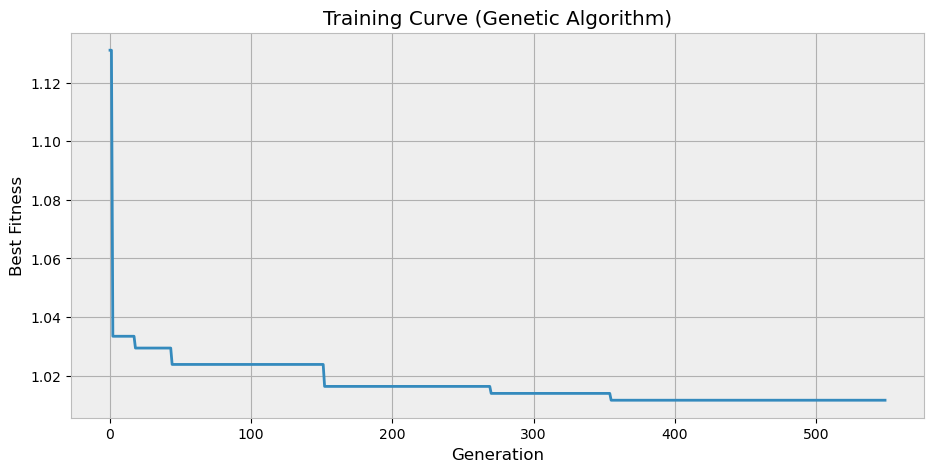

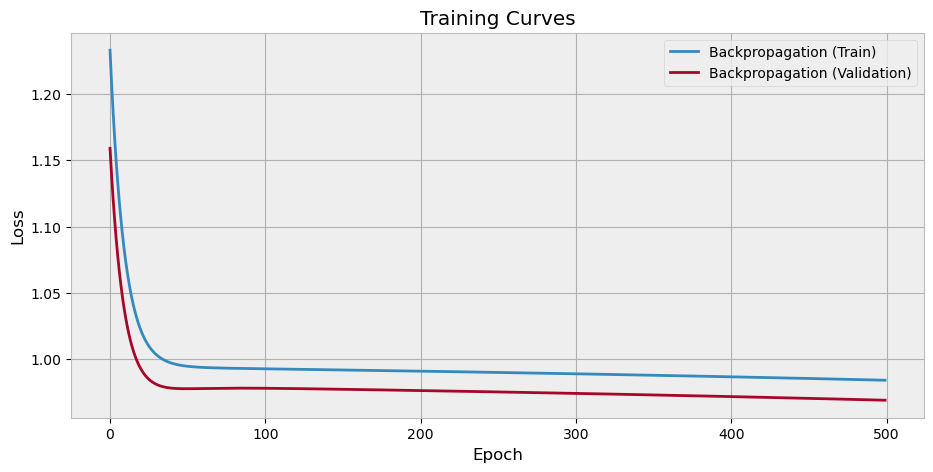

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Definimos la arquitectura de la red neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, X):
        X = self.sigmoid(self.layer1(X))
        X = self.sigmoid(self.layer2(X))
        X = self.layer3(X)
        return X
    
    def predict(self, X):
        with torch.no_grad():
            pred = self.forward(torch.tensor(X))  # Convierte X a un tensor de PyTorch
        return pred.numpy().flatten().round().astype(int)
    

# Funcion que hace lo mismo que get data XD
def prepare_data(path):
    data = pd.read_csv(path, sep=';')
    data = (data - data.mean()) / data.std()
    X = data.drop('quality', axis=1).values.astype(np.float32)
    Y = data['quality'].values.astype(np.float32)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, X_val, Y_train, Y_val

# Entrenamiento con backpropagation
def train_with_backpropagation(X_train, Y_train, X_val, Y_val, input_size, hidden_size1, hidden_size2, output_size, epochs):
    model = NeuralNet(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train))
        loss = criterion(outputs.view(-1), torch.tensor(Y_train))  # Aplanamos los tensores
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Calculamos la perdida en el conjunto de validacion
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val))
            val_loss = criterion(val_outputs.view(-1), torch.tensor(Y_val))  # Aplanamos los tensores
            val_losses.append(val_loss.item())

    return model, train_losses, val_losses




# Preparamos los datos
X_train, X_val, Y_train, Y_val = prepare_data('./wine+quality/winequality-white.csv')

# Definicion de la arquitectura de la red neuronal
input_size = X_train.shape[1]
hidden_size1 = 10  # Mismo que en el articulo
hidden_size2 = 5   # Mismo que en el articulo
output_size = 1    

# Entrenamiento con backpropagation
backprop_model, backprop_train_losses, backprop_val_losses = train_with_backpropagation(X_train, Y_train, X_val, Y_val, input_size, hidden_size1, hidden_size2, output_size, epochs=500)

# Entrenamiento con algoritmo genetico
gen_model = Gen_net(input_size, hidden_size1, hidden_size2, output_size)
genetic_algorithm = Gen_train(gen_model, parent_scalar=0.25, operator_probabilities={'crossover': 0.9, 'mutation': 0.9}, population_size=110)
genetic_model = genetic_algorithm.train(steps=550)

# Graficas de las curvas de aprendizaje
plt.plot(backprop_train_losses, label='Backpropagation (Train)')
plt.plot(backprop_val_losses, label='Backpropagation (Validation)')
#plt.plot(genetic_algorithm.losses, label='Genetic Algorithm')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.show()

# Matrices de confusion
# backprop_confusion = confusion(backprop_model, X_val, Y_val)
# genetic_confusion = genetic_algorithm.confusion(X_val, Y_val)
# print('Backpropagation - Confusion Matrix:')
# print(backprop_confusion)
# print()
# print('Genetic Algorithm - Confusion Matrix:')
# print(genetic_confusion)
# print()









In [7]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()